In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import  GridSpec
import csv
import seaborn as sns
import numpy as np

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw, AllChem
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 300,300
from IPython.display import display
from IPython.display import SVG,Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Lambda analyses
Given variable degrees of lambda spacing, what happens to SEM (kcal/mol) in solvated phase? How do they compare to FEP-NN predictions of SEM?

### General analysis

In [2]:
sems_high = []
num_lambdas_high = []
perts_high = []

sems_low = []
num_lambdas_low = []
perts_low = []

info_bucket = []

with open("compiled_mbar_freenrgs.csv", "r") as readfile:
    reader = csv.reader(readfile)
    next(reader)
    for row in reader:
        pert_name, tgt, num_lambda, difficulty = row[0].split("_")
        sem = float(row[-1])
        
        if difficulty == "HIGH":
            sems_high.append(sem)
            num_lambdas_high.append(int(num_lambda))
            perts_high.append(pert_name)
        else:
            sems_low.append(sem)
            num_lambdas_low.append(int(num_lambda))
            perts_low.append(pert_name)
        
        # append to collector for 2nd analysis.
        info_bucket.append([pert_name, tgt, int(num_lambda), difficulty, float(sem)])


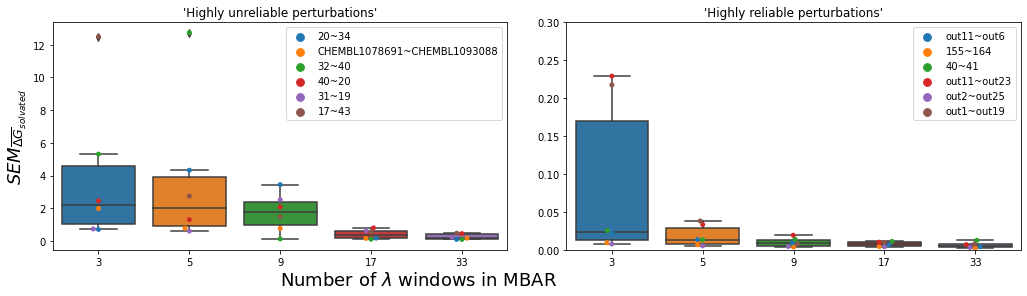

In [3]:
grid = GridSpec(1, 2,
                left=0.1, bottom=0.15, right=0.94, top=0.94, wspace=0.13, hspace=0.25)

fig = plt.figure(figsize=(16, 4))

ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[0, 1])

sns.boxplot(x=num_lambdas_high, y=sems_high, ax=ax1)
sns.swarmplot(x=num_lambdas_high, y=sems_high, hue=perts_high, ax=ax1)
sns.boxplot(x=num_lambdas_low, y=sems_low, ax=ax2)
sns.swarmplot(x=num_lambdas_low, y=sems_low, hue=perts_low, ax=ax2)

#ax1.set_ylim(0, 6)
ax2.set_ylim(0, 0.3)
ax1.set_ylabel("$SEM_{\overline{\Delta{G}}_{solvated}}$", size=18)
ax1.set_xlabel("Number of $\lambda$ windows in MBAR", size=18, ha="left")
ax1.set_title("'Highly unreliable perturbations'")
ax2.set_title("'Highly reliable perturbations'")

plt.show()

## Analyse versus FEP-NN prediction per perturbation.
For each perturbation, plot the SEM decay along lambda as well as the FEP-NN prediction and the molecular structures.

In [4]:
def getPredSEM(pert_name, tgt):
    """Finds the SEM as predicted by the most recently run FEPNN and the FEP-Space derivative SMILES."""
    
    df = pd.read_csv(f"../../perturbation_networks/output/series_predictions/{tgt}.csv")
    pred_sem = df[df["pert_name"] == pert_name]["pred_sem_mean"].values[0]
    fepspace_smiles = df[df["pert_name"] == pert_name]["fepspace_pert"].values[0]
    
    return pred_sem, fepspace_smiles

In [5]:
def depictMol(mol):
    """Saves a molecule image and loads it back in and returns it. Allows viewing RDKit molecules during 
    loop iterations. """
    AllChem.Compute2DCoords(mol)
    Draw.MolToFile(mol, "tmp_imgs/tmp.png")

    img = mpimg.imread("tmp_imgs/tmp.png")
    
    return img  

hif2a
cdk8
cdk8
cdk8
cdk8
cdk8
cdk8
eg5
shp2
shp2
shp2
shp2


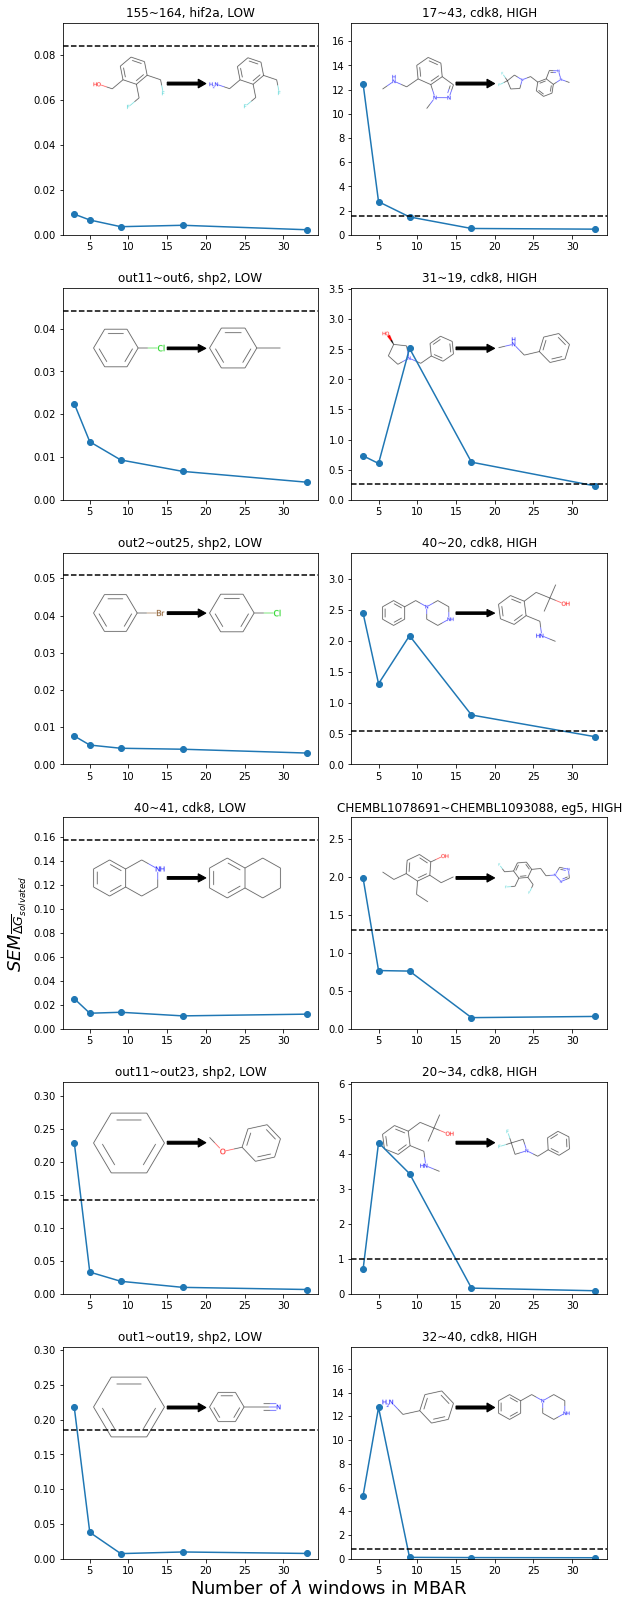

In [6]:
info_df = pd.DataFrame.from_records(info_bucket)

info_df.columns = ["pert_name", "tgt", "num_lambda", "type", "sem"]

# info_df = info_df[info_df["tgt"] == "cdk8"] # restrict to single target.


grid = GridSpec(6, 2,
                left=0.1, bottom=0.15, right=0.94, top=0.94, wspace=0.13, hspace=0.25)

fig = plt.figure(figsize=(9, 27))

ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[0, 1])
ax3 = fig.add_subplot(grid[1, 0])
ax4 = fig.add_subplot(grid[1, 1])
ax5 = fig.add_subplot(grid[2, 0])
ax6 = fig.add_subplot(grid[2, 1])
ax7 = fig.add_subplot(grid[3, 0])
ax8 = fig.add_subplot(grid[3, 1])
ax9 = fig.add_subplot(grid[4, 0])
ax10 = fig.add_subplot(grid[4, 1])
ax11 = fig.add_subplot(grid[5, 0])
ax12 = fig.add_subplot(grid[5, 1])

for (pert_name, cols), ax in zip(info_df.groupby(by="pert_name"),
                                [ax1,
                                ax2,
                                ax10, # swapped order to get a neat LOW/HIGH on left/right columns
                                ax4,
                                ax12,
                                ax6,
                                ax7,
                                ax8,
                                ax9,
                                ax3,
                                ax11,
                                ax5]
                                ):
    cols.sort_values(by="num_lambda", inplace=True)
    tgt = cols["tgt"].values[0]
    print(tgt)
    sems = cols["sem"].values
    num_lambdas = cols["num_lambda"].values
    pred_sem, fepspace_smiles = getPredSEM(pert_name, tgt)
    
    # get SMILES of both input ligands and convert to image for matplotlib to plot.
    img0 = depictMol(Chem.MolFromSmiles(fepspace_smiles.split("~")[0]))
    img1 = depictMol(Chem.MolFromSmiles(fepspace_smiles.split("~")[1]))
    
    if max(sems) > pred_sem:
        max_y = max(sems)
    else:
        max_y = pred_sem*0.8
    dy = max_y - min(sems)
      
    
    ax.imshow(img0, extent=[5, 15, max_y*0.75, max_y*1.25], origin="upper", aspect='auto')
    
    ax.arrow(x=15, y=max_y, dx=5, dy=0, width=dy*0.02, head_length=1, length_includes_head=True,
            color="black")
    
    ax.imshow(img1, extent=[20, 30, max_y*0.75, max_y*1.25], origin="upper", aspect='auto')
    
    
    
    ax.plot(num_lambdas, sems, '-o')
    ax.axhline(pred_sem, ls="--", color="black")
    ax.set_title(f"{pert_name}, {tgt}, {cols['type'].values[0]}")
    ax.set_ylim(0, max_y*1.4)

ax7.set_ylabel("$SEM_{\overline{\Delta{G}}_{solvated}}$", size=18)
ax11.set_xlabel("Number of $\lambda$ windows in MBAR", size=18, ha="left")
plt.show()
